# Introduction
This practical 2 is designed to learn about a multi-sensor data fusion approach to evaluate soil compaction, and prediction of soil properties. We collected snesor data as well as soil samples for soil analysis pupuses. Datasets below are almost raw files without major processing. Usually, this notebook should be ready to run in GoogleColab. You need to put all files in one of your local drive, and log in to your google account when needed during script runing.

In [99]:
# import libaries required to run this notebook
!pip install geopandas
!pip install pykrige
!pip install contextily

import pickle
import numpy as np
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from pykrige.ok import OrdinaryKriging
from shapely.geometry import Point
from shapely.geometry.polygon import Polygon
from scipy.interpolate import griddata
from scipy.stats import pearsonr
from sklearn.metrics import r2_score
import contextily as cx

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Datasets

In [100]:
# Conneting colab to load local files. if the below option 1 doesn't work somehow

# from google.colab import files
# uploaded = files.upload()

Saving ESS_2023_Penetrolog.csv to ESS_2023_Penetrolog (1).csv
Saving ess23_boundary.geojson to ess23_boundary (2).geojson
Saving On-line_scan.csv to On-line_scan (2).csv
Saving plsr_coeffs.pkl to plsr_coeffs (2).pkl
Saving Soil_Obs_ESS2023.csv to Soil_Obs_ESS2023 (2).csv
Saving Soil_Pred_ESS2023.csv to Soil_Pred_ESS2023 (2).csv


In [129]:
# Loading data

# Loading data option 1
dataset1 = 'https://users.ugent.be/~pjdsmedt/ESS2023/on-line_scan.csv'
dataset2 = 'https://users.ugent.be/~pjdsmedt/ESS2023/ESS_2023_Penetrolog.csv'
dataset3 = 'https://users.ugent.be/~pjdsmedt/ESS2023/Soil_Obs_ESS2023.csv'
dataset4 = 'https://users.ugent.be/~pjdsmedt/ESS2023/ess23_boundary.geojson'
dataset5 = 'https://users.ugent.be/~pjdsmedt/ESS2023/plsr_coeffs.pkl'

df_raw = pd.read_csv(dataset1, sep=',', header=0)
df_pn = pd.read_csv(dataset2, sep=',', header=0)
df_obs = pd.read_csv(dataset3, sep=',', header=0)
boundary = gpd.read_file (dataset4)
plsr = pickle.load(open(dataset5, 'rb'))

df_paras = df_raw.loc[(df_raw['lat'] > 0) & (df_raw['lon'] > 0), "lat":"loadcell_mv"]
df_sp = df_raw.iloc[:, df_raw.columns.get_loc("loadcell_mv") + 1:][df_raw['lat'] > 0]
wl = np.arange(305,1701)
scan = gpd.GeoDataFrame(
    df_paras, geometry=gpd.points_from_xy(df_paras['lat'],df_paras['lon']), crs='EPSG:4326'
    )


# # Loading data option 2
# # plsr model was saved as pickle framwork, making it easy, compatible and secure usages.
# plsr = pickle.load(open("plsr_coeffs.pkl", "rb"))

# # Spectra data
# df_raw = pd.read_csv('On-line_scan.csv')
# df_paras = df_raw.loc[(df_raw['lat'] > 0) & (df_raw['lon'] > 0), "lat":"loadcell_mv"]
# df_sp = df_raw.iloc[:, df_raw.columns.get_loc("loadcell_mv") + 1:][df_raw['lat'] > 0]

# wl = np.arange(305,1701)

# # Penetrolog
# df_pn = pd.read_csv('ESS_2023_Penetrolog.csv')

# # Geodata
# boundary = gpd.read_file("ess23_boundary.geojson");

# scan = gpd.GeoDataFrame(
#     df_paras, geometry=gpd.points_from_xy(df_paras['lat'],df_paras['lon']), crs='EPSG:4326'
#     )
# #  Loading field observed data of soil moisture, bulk density, and prenetration resistance.
# df_obs = pd.read_csv("Soil_Obs_ESS2023.csv")


HTTPError: ignored

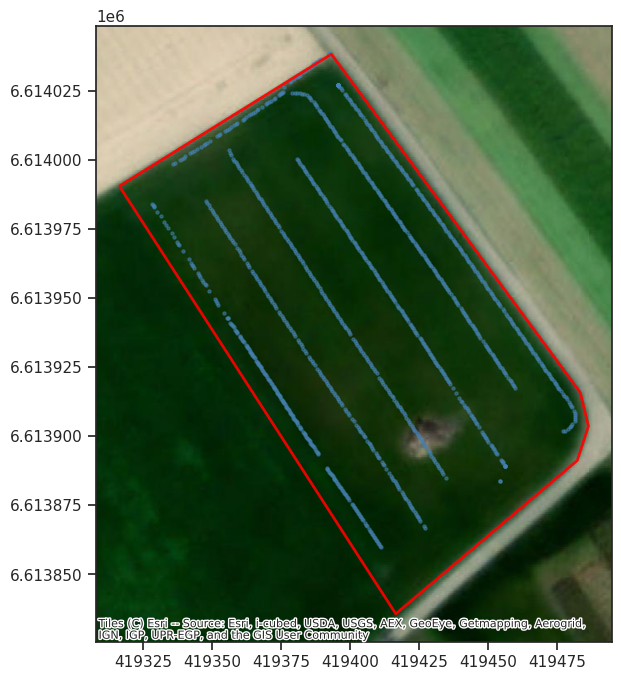

In [102]:
# Field location and scanning transect

# Reproject the GeoDataFrame to EPSG 3857

df_pts = scan.to_crs(epsg=3857)
df_bor = boundary.to_crs(epsg=3857)

# Plot the GeoDataFrame with the Esri.WorldImagery basemap

fig, ax = plt.subplots(figsize=(8, 8))
df_pts.plot(ax=ax, alpha=0.5, facecolor='steelblue', edgecolor="steelblue", linewidth=1, markersize=5)
df_bor.plot(ax=ax, alpha=0.9, facecolor='none', edgecolor="red", linewidth=2)
cx.add_basemap(ax, source=cx.providers.Esri.WorldImagery, zoom=19)

plt.show()


# Exploring observed data

In [103]:
# Raw data sheet after field measurement
  # Looking at the overll data matrices w can see each row standa for a single measurement, recording with geolocation, potentiometer, loadcell and continous wavespectrum of 305-1700 nm. 
df_raw.head()

,idx,lat,lon,potentiometer_v,loadcell_mv,305,306,307,308,309,...,1691,1692,1693,1694,1695,1696,1697,1698,1699,1700
0,0,3.767466,50.958965,7.593520,124.99997,15.92794,16.72705,16.71891,16.07581,14.64098,...,11.79572,13.04509,8.96508,7.82945,11.93007,14.71020,14.31418,8.09155,4.61187,4.81699
1,1,3.767466,50.958965,7.592232,124.99997,9.34008,8.06370,5.65078,2.23635,0.27627,...,9.15729,10.88205,7.35968,5.62987,7.03731,8.28128,8.42263,6.34729,4.09122,1.87687
2,2,3.767466,50.958965,7.592375,124.99997,14.10878,16.88647,17.29174,15.75821,14.52439,...,10.43384,12.71678,10.10003,9.57376,12.55777,15.29759,16.66988,15.40280,13.57394,11.35535
3,3,3.767466,50.958965,7.592211,124.99997,0.00000,0.10858,0.48124,0.06650,0.00186,...,9.22105,9.30643,7.80601,7.84293,10.70317,12.41598,11.78273,6.98597,4.11208,3.83707
4,4,3.767466,50.958965,7.592547,124.99997,8.25222,8.17228,6.13202,2.45545,0.30984,...,8.67831,10.16792,8.44414,8.27119,11.21068,12.32375,10.34511,2.78916,0.38594,4.04539


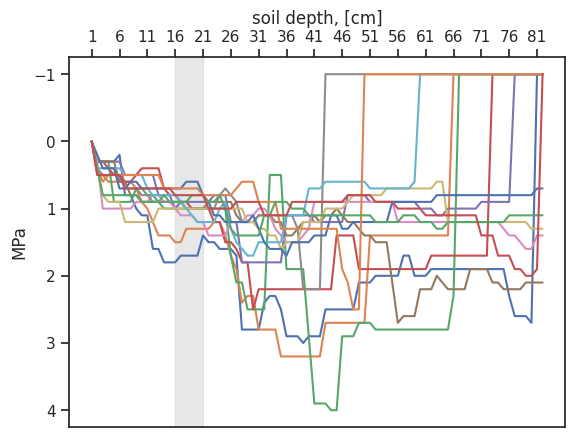

In [104]:
# Explor the penetrologging data
# This function is the illustrate penetration resistance against the soil depth.

def plot_penitro(df):
    # Select the first 10 rows from the DataFrame
    subset = df.head(10)

    # Create a new figure and axis
    fig, ax = plt.subplots()

    # Iterate over each row of the subset
    for index, row in df.iterrows():
        x_values = row.index
        y_values = row.values

        # Plot the line with y-axis going downwards
        ax.plot(x_values, y_values)

    # Reverse the y-axis direction
    ax.invert_yaxis()

    # Move the x-axis ticks and label to the top
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')

    # Set the axis label
    ax.set_xlabel('soil depth, [cm]')
    ax.set_ylabel('MPa')
    
    # Reduce x-axis tick frequency and rotate labels
    x_ticks = range(0, len(df.columns), 5)
    ax.set_xticks(x_ticks)
    # ax.set_xticklabels(df.columns[x_ticks], rotation=45, ha='right')

    # Add a vertical strip from 15 to 20 columns
    ax.axvspan(15, 20, color='lightgray', alpha=0.5)
    # Display the plot
    plt.show()

# Now plot it
df_pr = df_pn.iloc[:, 3:]
plot_penitro(df_pr)

descriptives:
              bd         mc         pr
count  14.000000  14.000000  14.000000
mean    1.470336   0.276119   0.989286
std     0.059304   0.034735   0.276084
min     1.347000   0.222222   0.650000
25%     1.448575   0.254876   0.875000
50%     1.491150   0.271177   0.950000
75%     1.503550   0.292469   1.000000
max     1.540800   0.335850   1.733333


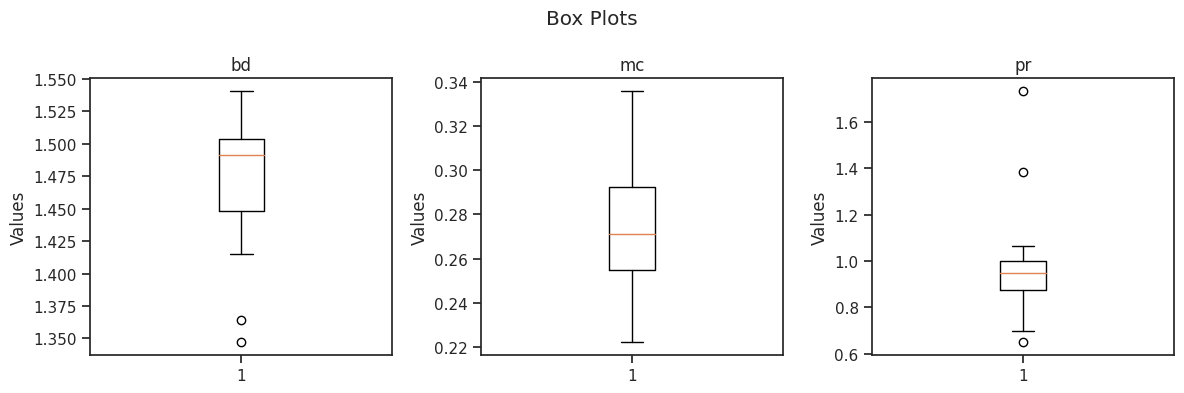

Pearson correlation coefficients:
          bd        mc        pr
bd  1.000000 -0.718243  0.298139
mc -0.718243  1.000000 -0.449192
pr  0.298139 -0.449192  1.000000


In [105]:
# Observed data
# Statistics
subset = df_obs.loc[:,'bd':'pr']

print("descriptives:")
print(subset.describe())

# Boxplots
def plot_boxplot(df, columns):
    # Select the specified columns from the DataFrame
    subset = df[columns]

    # Create a new figure and subplots
    fig, axes = plt.subplots(nrows=1, ncols=len(columns), figsize=(12, 4))

    # Iterate over each column
    for i, col in enumerate(columns):
        # Plot the box plot on the corresponding subplot
        axes[i].boxplot(subset[col].values)

        # Set the y-axis label
        axes[i].set_ylabel('Values')

        # Set the title of the subplot
        axes[i].set_title(col)

    # Set the title of the overall plot
    fig.suptitle('Box Plots')

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Display the plot
    plt.show()
    
plot_boxplot(subset, ['bd', 'mc', 'pr'])

# Correlation
print("Pearson correlation coefficients:")
print(subset.corr())

# Vis-NIRS for soil prediction
We have on-line measured vis-NIRS soil sepctra (1168) collected from the test field. Now, its time to transform the spectral information into usefull information, soil moisture content (MC) in our case. To be able to model and predict soil MC using vis-NIRS spectra requires enough number of sample data, say 100 observations at least but more is better, but we collected only 14 samples. So, we can take more observation from availale spectra library and develop a reatively bigger dataset and train a spectral model. We have alrady developed such a model using partial least squares regression (PLSR) analysis. PLSR is very common multivariate technique for spectral calibration, and it attemtpds to maxmise covariances between dependent and independt variables by generating latent variables from spectral data. Latent avriables are orthogonals scores, often known as number of conponents. More details on PLSR can be found here https://en.wikipedia.org/wiki/Partial_least_squares_regression#:~:text=Partial%20least%20squares%20regression%20(PLS,the%20predicted%20variables%20and%20the.

Here, you can find parameters extructed from the previous PLSR model conprising of coefficient matrix, mean spectra in model training, and mean MC of the traning dataset. Thses parameters will be required for the MC prediction using the large of spectral samples. However, spectral data needs to be propcessed before feedding to PLSR for MC prediction. Note that specta processing should follow the similar processing steps as used in model calibration. Here are the steps-
1. Rolling window averaging to reduce spectral noise
3. Triming out the spectral edge noise
4. Standardization of spectra range to scale down variances to 0 to 1

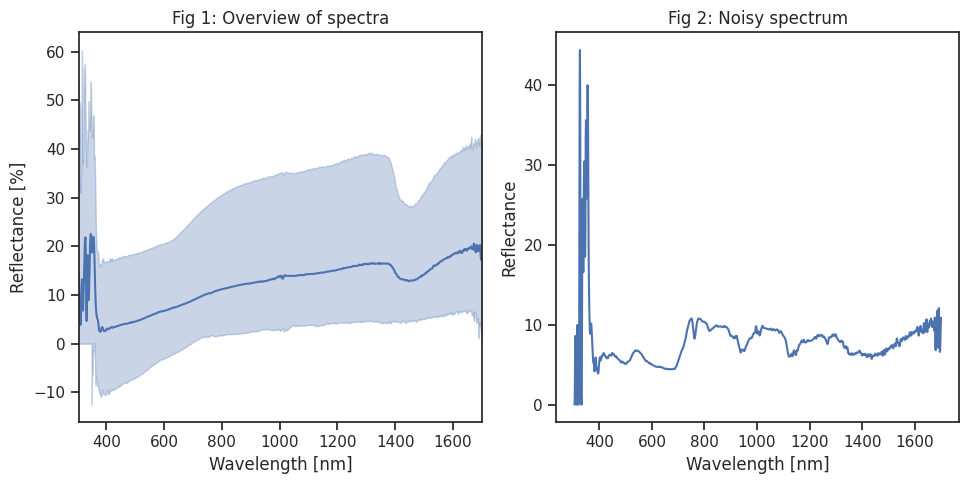

In [106]:
# Spectral pattern
    # Look at the shape of the spectra showing a mean of all spectra with min and max reflectances.
    # The mean spectra looks like a standard soil spectra, indicating a strong feature around 1450 nm for soil moisture content. More the soil moisture, more prominent feature can be visible.
    # Highly spiked reflectance below 350 nm is usually a randon noise, and small noisy part is also visible after 1680 nm. Such noisy portions are usially not usful in soil analysis.
    # Due to the highly rough field conditions (vibrations, sensor-to-soil distance, ambient temperature, input power stability, etc.), can lead to a number of noisy spectra, see fig 2.
    # So, an inital spectra filtering has been carried out here, even we still have some noisy spectra.

sns.set(style="ticks")

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

# Plot on the first subplot
axes[0].plot(wl, df_sp.mean(), 'b')
axes[0].fill_between(wl, df_sp.min(), df_sp.max(), color='b', alpha=0.3)
axes[0].set_title('Fig 1: Overview of spectra')
axes[0].set_ylabel('Reflectance [%]')
axes[0].set_xlabel('Wavelength [nm]')
axes[0].set_xlim([min(wl), max(wl)])

# Plot on the second subplot
axes[1].plot(wl, df_sp.values[753, :])
axes[1].set_title('Fig 2: Noisy spectrum')
axes[1].set_ylabel('Reflectance')
axes[1].set_xlabel('Wavelength [nm]')

plt.tight_layout()  # Adjust subplot spacing
plt.show()


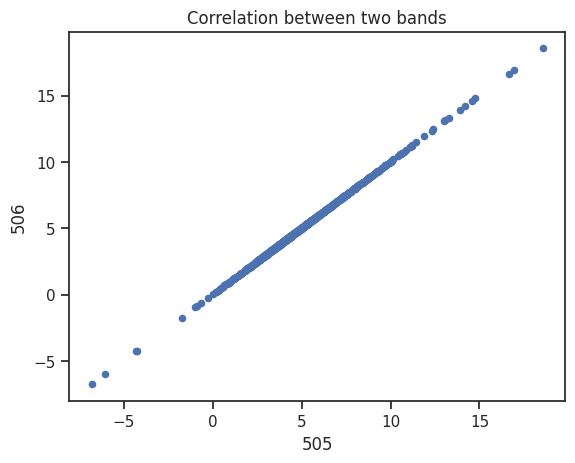

In [107]:
# Correlation between spectra bands
    # Spectral data are highly correlated. So, one should opt for a multivariate calivration method that can hande such multicoliearity, i.e., PLSR.

df_sp.plot.scatter(200,201)
plt.title('Correlation between two bands')
plt.show()

In [108]:
# Spectra preprocessing
    # In order to remove noises and improve the singal, spectra should be preprocessed but should be as same as the model to use in predictioion.
    # Preprocessing includes- 1. rolling average, 2. edge triming, 3. standardization. Here is a function defined for a specific model we loaded as pickle module.
    # This preprocess_and_plot fnction will use our input dataset, execute all preproceesing algorithms, plot and provide a return dataframe ready to use in prediction of soil MC. 

def preprocess_and_plot(df, wl):
    # Smoothing the data
    df_sp_smooth = df.rolling(window=15, closed='neither', center=True, min_periods=1, axis="columns").mean()

    # Create subplots
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    # Plot raw and smoothed data
    axs[0, 0].plot(wl, df.mean(), 'r', label='raw')
    axs[0, 0].plot(wl, df_sp_smooth.mean(), 'b', label='smoothed')
    axs[0, 0].set_title('Fig 1: rolling avg. spectra')
    axs[0, 0].set_ylabel('Reflectance [%]')
    axs[0, 0].set_xlabel('Wavelength [nm]')
    axs[0, 0].set_xlim([min(wl), max(wl)])
    axs[0, 0].legend(loc='upper right')

    # Trimming the columns
    df_sp_trim = df_sp_smooth.iloc[:, 155:df_sp_smooth.shape[1] - 30]
    wl_trim = wl[155:df_sp_smooth.shape[1] - 30]

    # Plot smoothed and trimmed data
    axs[0, 1].plot(wl, df_sp_smooth.mean(), 'r', label='smoothed')
    axs[0, 1].plot(wl_trim, df_sp_trim.mean(), 'b', label='trimmed')
    axs[0, 1].set_title('Fig 2: trim spectra')
    axs[0, 1].set_ylabel('Reflectance [%]')
    axs[0, 1].set_xlabel('Wavelength [nm]')
    axs[0, 1].set_xlim([min(wl), max(wl)])
    axs[0, 1].legend(loc='upper right')

    # Standardizing the data
    scaler = MinMaxScaler(feature_range=(0, 1)).fit(df_sp_trim.T)
    df_sp_stand = df_sp_trim.copy()
    df_sp_stand.iloc[:, :] = scaler.transform(df_sp_trim.T).T

    # Plotting trimmed and standardized data
    axs[1, 0].plot(wl_trim, df_sp_trim.mean(), 'r', label='trimmed')
    axs[1, 0].set_title('Fig 3: trim spectra only')
    axs[1, 0].set_ylabel('Reflectance [%]')
    axs[1, 0].set_xlabel('Wavelength [nm]')
    axs[1, 0].set_xlim([min(wl_trim), max(wl_trim)])
    axs[1, 0].legend(loc='upper right')

    axs[1, 1].plot(wl_trim, df_sp_stand.mean(), 'b', label='standardized')
    axs[1, 1].set_title('Fig 4: standardized spectra')
    axs[1, 1].set_xlabel('Wavelength [nm]')
    axs[1, 1].set_xlim([min(wl_trim), max(wl_trim)])
    axs[1, 1].legend(loc='upper right')

    # Adjust spacing between subplots
    fig.tight_layout()

    # Show the plots
    plt.show()

    return df_sp_stand


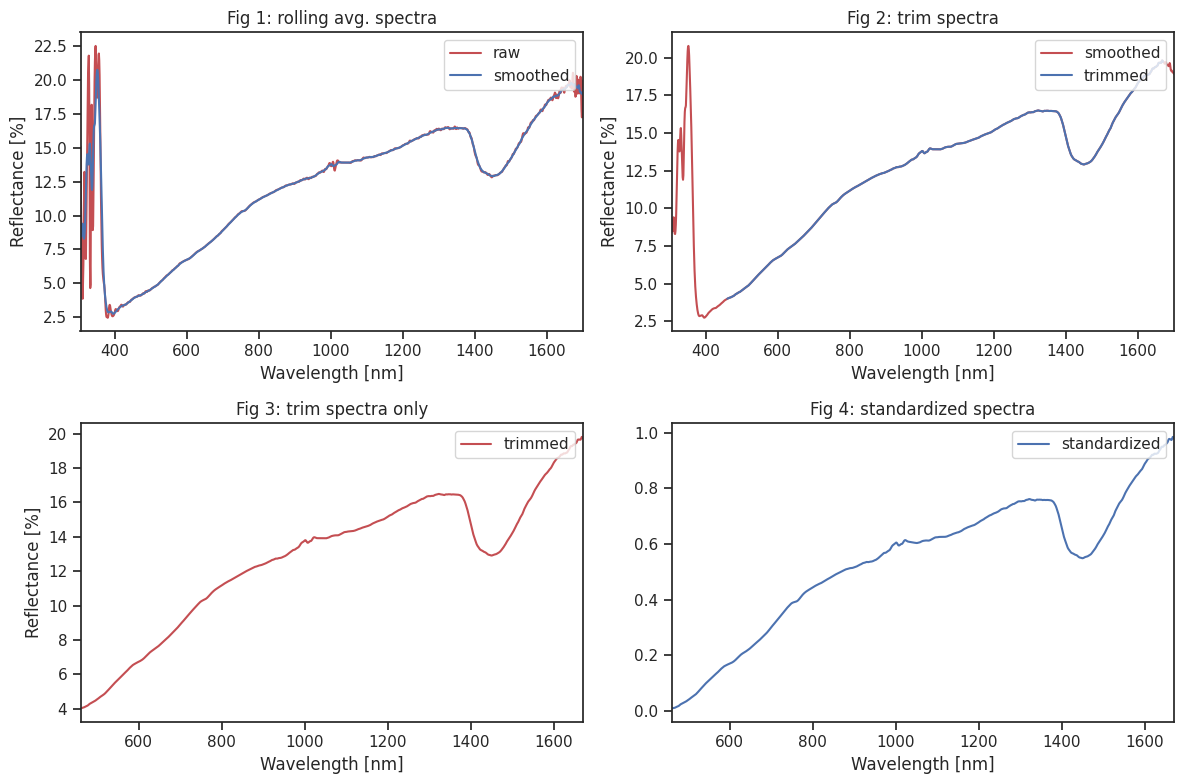

In [ ]:
# Let's do preprocessing and plot mean spectra
df_sp_stand = preprocess_and_plot(df_sp,wl=wl)

In [109]:
# Prediction of soil moisture contet [MC]
    # The loop iterates over the rows of the preprocessed dataframe df_sp_stand using the range(df_sp_stand.shape[0]) statement.
    # Within each iteration, calculations are performed to compute Y, and the resulting Y value is appended to the mc list using the mc.append(Y) statement.
    # Therefore, mc is a list that stores the calculated Y values for each row of the df_sp_stand dataframe.

mc = []
for i in range(df_sp_stand.shape[0]):
    X_c = df_sp_stand.iloc[i,:] - plsr['Xmeans'].iloc[:,1].values
    Y_c = sum(X_c * plsr['Coeff'].values[:,-1])
    Y = (Y_c + plsr['Ymeans'])/100
    mc.append(Y)

df_paras['mc'] = mc


# Soil physical properties

Now we have MC prediction using on-line vis-NIRS spectra. Its time to calculate bult density, packing dencity, and draught and draft forces using the data recorded during field measurement. As mentioned earlier, the multi-sensor recorded data from a force sensor, depth sensor along the vis-NIR spectra. 
Step 1: Convert raw electrical signal to useable unit required for our functions explain in ppt. For sxample, potnetiometer (V) to potentiometer (m); loadcell (mV) to kN.
Step 2: Calculate depth, fraft firse, bd and pd.

In [110]:
# Convert raw signal
potentiometer_v = df_paras['potentiometer_v'].values
loadcell_mv = df_paras['loadcell_mv'].values

# convert voltage reading to meter/kilo-newton
potentiometer_m = 0.0289*potentiometer_v
loadcell_kn = 1.122*loadcell_mv- 0.119


In [111]:
# Calculate depth, fraft force, bd and pd.
lon = df_paras['lon'].values
lat = df_paras['lat'].values
mc = df_paras['mc'].values

# # Plot
# plt.scatter(lon,lat)
# plt.show()

# soil texture
sand = 0.359
silt = 0.418
clay = 0.223

# Calculate sensing depth
d_m = 0.72-2.46*(np.sqrt(1.1657*np.power(potentiometer_m ,2)-3.6982*np.power(potentiometer_m ,4)-0.0019))
d_m = np.round(d_m, 3)

# Calculate draft force
fd_kn = 0.216*(loadcell_kn-0.5)
fd_kn = np.round(fd_kn, 3)

# Calculate bulk density 
cf = 0.089-0.427*df_paras['mc'].values-0.127*sand-1.090*np.power(clay,3)   # correcting factor
rho_bd = np.power( ( (fd_kn + 21.36*df_paras['mc'].values - 73.9313* np.power(d_m,2) )/1.6734), (1/3) ) * (1.255 - 0.772*df_paras['mc'].values)+cf
rho_bd = np.round(rho_bd, 3)

# Calculate packing density
rho_pd = rho_bd+0.9*clay   # don't use pd as variable name as it is for pandas!!!
rho_pd = np.round(rho_pd, 3)

#save results
out_file = "ess23_pred.csv"
out_data = np.vstack([lat, lon, mc, d_m, fd_kn, rho_bd, rho_pd]).T
out_header = ['lat', 'lon', 'mc', 'd_m', 'fd_kn', 'bd', 'pd']
df_out = pd.DataFrame(data = out_data, columns=out_header)
df_out.to_csv(out_file, index=False)
df_out.describe()

,lat,lon,mc,d_m,fd_kn,bd,pd
count,1165.000000,1165.000000,1165.000000,1165.000000,1165.000000,1165.000000,1165.000000
mean,3.767575,50.958478,0.270660,0.188737,3.014402,1.484276,1.685276
std,0.000295,0.000249,0.037475,0.042805,4.281320,0.201406,0.201406
min,3.766890,50.957955,0.202059,-0.017000,-0.501000,1.286000,1.487000
25%,3.767368,50.958288,0.247020,0.184000,1.928000,1.415000,1.616000
50%,3.767554,50.958470,0.265527,0.196000,2.428000,1.462000,1.663000
75%,3.767776,50.958667,0.285231,0.208000,2.974000,1.499000,1.700000
max,3.768265,50.958965,0.545548,0.302000,30.160000,2.837000,3.038000


However, On-line collected sensors data are usually come with a lot of noisy spectra, and thus noisy prediction as well even if we have a excellent model. So it is now time to remove outliers values. We can remove outliers by using many methods (e.g., Z-score, IQR, Percentile etc) but let use percentiel for this case. This method works by setting a particular threshold value, which is decided based on the problem statement. While we remove the outliers by capping, then it is known as Winsorization method. It is suggested to maintain a balance removal from both ends i.e., if we remove 5% from the bottom side of distribution then 5% also from upper side. You can also choose data range based on the actual mesured data to filter outliers.


In [112]:
# Function for calculating percentaile we want to keep
def calculate_limits(df, columns, quantiles=[0.01, 0.95]):
    limits = {}
    for column in columns:
        upper_limit = df[column].quantile(quantiles[1])
        lower_limit = df[column].quantile(quantiles[0])
        limits[column] = {'upper_limit': upper_limit, 'lower_limit': lower_limit}
    return pd.DataFrame(limits)

# Example usage:
limits = calculate_limits(df_out, ['mc', 'd_m', 'fd_kn', 'bd', 'pd'])
print(limits)

df_out.describe()

                   mc    d_m   fd_kn       bd       pd
upper_limit  0.326505  0.227  4.0938  1.57180  1.77280
lower_limit  0.217191 -0.014 -0.4990  1.31828  1.51928


,lat,lon,mc,d_m,fd_kn,bd,pd
count,1165.000000,1165.000000,1165.000000,1165.000000,1165.000000,1165.000000,1165.000000
mean,3.767575,50.958478,0.270660,0.188737,3.014402,1.484276,1.685276
std,0.000295,0.000249,0.037475,0.042805,4.281320,0.201406,0.201406
min,3.766890,50.957955,0.202059,-0.017000,-0.501000,1.286000,1.487000
25%,3.767368,50.958288,0.247020,0.184000,1.928000,1.415000,1.616000
50%,3.767554,50.958470,0.265527,0.196000,2.428000,1.462000,1.663000
75%,3.767776,50.958667,0.285231,0.208000,2.974000,1.499000,1.700000
max,3.768265,50.958965,0.545548,0.302000,30.160000,2.837000,3.038000


In [113]:
# Let's remove outliers
max_val = limits['mc'].values[0]; min_val = limits['mc'].values[1];
df_MC = df_out[(df_out['mc'] >= min_val) & (df_out['mc'] <= max_val)]

df_MC.describe()

,lat,lon,mc,d_m,fd_kn,bd,pd
count,1094.000000,1094.000000,1094.000000,1094.00000,1094.000000,1094.000000,1094.000000
mean,3.767580,50.958473,0.265289,0.19346,2.929979,1.476533,1.677533
std,0.000282,0.000245,0.023817,0.03054,3.799934,0.181838,0.181838
min,3.766890,50.957955,0.217233,-0.01500,-0.501000,1.286000,1.487000
25%,3.767380,50.958289,0.246719,0.18500,1.939250,1.411500,1.612500
50%,3.767562,50.958463,0.263481,0.19600,2.431500,1.461000,1.662000
75%,3.767775,50.958660,0.281522,0.20800,2.944750,1.496750,1.697750
max,3.768265,50.958965,0.326375,0.30200,30.160000,2.837000,3.038000


# Soil mapping

Let's create surface of soil moisture by kriging interpolation. Krging is a geostatistcial interpolation method that takes sptial autocorreation as well as the distances between measured and unsamples location. Variogram model is required to capture spatial stuctures of variation as a function of covariances and lag distances. A typical variogram model provides range, sill, partial sill, nugget, and type fit parameters in prediction. For more details, https://en.wikipedia.org/wiki/Kriging. This is practical our main focus is not executing krigining, but to use it creatinh sruface of the soil properties we estimated using the multi-sensor fusion data. Let's do an example for soil moisture mapping.

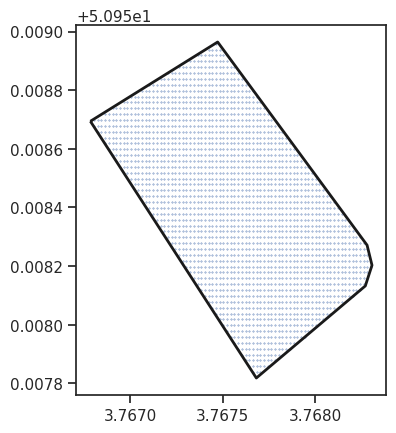

In [114]:
#  Kriging interpolation to create layer from points

# define function to have a grid within field border
def create_grid_xy_within_boundary(boundary_in, grid_step):
    _grid_x = np.arange(boundary_in.bounds.minx[0], boundary_in.bounds.maxx[0], grid_step)
    _grid_y = np.arange(boundary_in.bounds.miny[0], boundary_in.bounds.maxy[0], grid_step)
    _grid_coords = np.array(np.meshgrid(_grid_x, _grid_y)).T.reshape(-1, 2)
    _points = [Point(coord[0], coord[1]) for coord in _grid_coords]
    _if_points_inside = boundary_in.geometry[0].contains(_points)
    grid_x= _grid_coords[_if_points_inside,0]
    grid_y = _grid_coords[_if_points_inside,1]
    return grid_x, grid_y

# Load field boundary as geojson
lon_k, lat_k =  create_grid_xy_within_boundary(boundary, 0.00002)

# Plot grid
_, ax = plt.subplots()
ax.scatter(lon_k, lat_k, s=0.1)
boundary.boundary.plot(color=None,edgecolor='k',linewidth = 2, ax = ax)
plt.show()

Plotting Enabled

Adjusting data for anisotropy...
Initializing variogram model...
Coordinates type: 'euclidean' 

Using 'power' Variogram Model
Scale: 1.5365023861959175
Exponent: 1.0935835259013231
Nugget: 0.00019656138434502647 



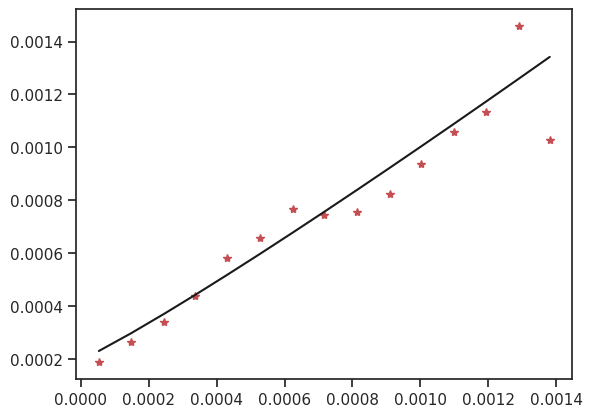

Calculating statistics on variogram model fit...
Executing Ordinary Kriging...



In [119]:
# Create an instance of the OrdinaryKriging class

x = df_MC['lat'].values
y = df_MC['lon'].values
z = df_MC['mc'].values
kriging_model = OrdinaryKriging(x, y, z, variogram_model="power",  verbose=True, enable_plotting=True,nlags=15, weight=True, anisotropy_angle=45)
mc_k, _ = kriging_model.execute('points', lon_k, lat_k)

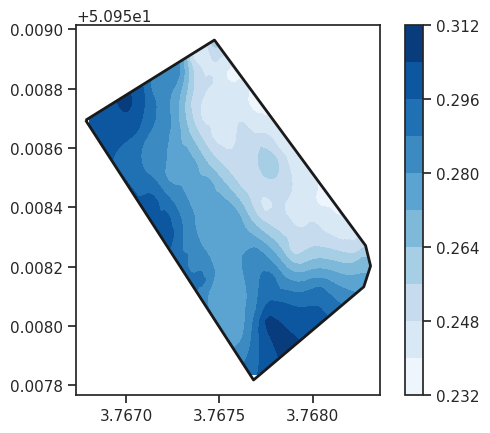

In [120]:
#  Interpolated layer [MC]

_, ax = plt.subplots()
boundary.boundary.plot(color=None,edgecolor='k',linewidth = 2, ax = ax)
tcf = ax.tricontourf(lon_k, lat_k, mc_k, levels=9, cmap='Blues')
plt.colorbar(tcf)
plt.xlim([boundary.bounds.minx[0]-0.00005, boundary.bounds.maxx[0]+0.00005])
plt.ylim([boundary.bounds.miny[0]-0.00005, boundary.bounds.maxy[0]+0.00005])
plt.show()

# Association among sensors data

Let's see at what degree fo association sensor data has achived with measured data. For this, we can do many types of statistical analyses, but we can focus in some simple statistics. Firstly, we must need to extract values valuse from the krigning layer concerning the sampling location. Once we have that colocated data points, we will do- 1. check distibution of both predicted and observed values; 2. Pearsons'correlation, 3. linear fit evaluated by coefficient of determination.

In [121]:
# Function for interpolating data at sampling location. 
# This function allow you to select several of interpolation methods i.e., liner, cubic, nearest, spline, and will provide a dataframe. We will opt for nearest method

def interpolate_z2(x1, y1, z1, x2, y2, method='nearest'):
    # Interpolate the values of z1 at the points specified by x2 and y2
    z2 = griddata((x1, y1), z1, (x2, y2), method=method)

    # Convert x2, y2, and z2 to a Pandas DataFrame
    df = pd.DataFrame({'lat': x2, 'lon': y2, 'z2': z2})

    return df

# Interpolate
df_pred = interpolate_z2(lon_k, lat_k, mc_k, df_obs['lon'].values,df_obs['lat'].values)
df_pred.rename(columns={'z2': 'mc_pred'}, inplace=True)

df_pred

,lat,lon,mc_pred
0,3.767317,50.958867,0.267293
1,3.767433,50.958783,0.247568
2,3.767650,50.958600,0.250243
3,3.767850,50.958433,0.249440
4,3.768055,50.958310,0.247912
5,3.766933,50.958650,0.298253
6,3.767100,50.958483,0.291234
7,3.767300,50.958267,0.287555
8,3.767633,50.957967,0.280333
9,3.767767,50.958000,0.305494


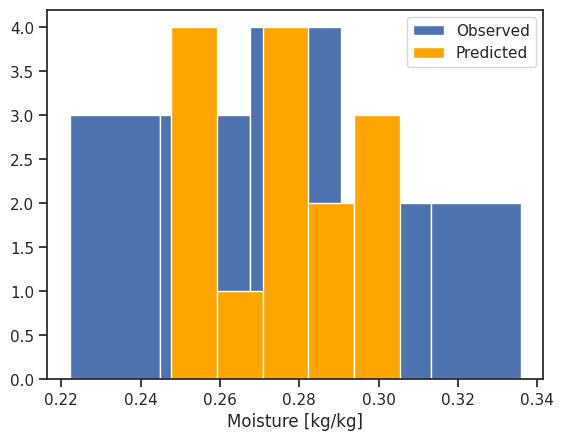

In [122]:
# Distribution similarity between predicted and measured variables

# data distribution
plt.hist(df_obs['mc'].values, bins=5, label='Observed')
plt.hist(df_pred['mc_pred'].values, bins=5, color='orange', label='Predicted')
plt.xlabel('Moisture [kg/kg]')
plt.legend(loc='upper right')
plt.show()

In [123]:
#  Pearson correlation
print(pearsonr(df_obs['mc'], df_pred['mc_pred'].values))

PearsonRResult(statistic=0.610892122882615, pvalue=0.0203006777426847)


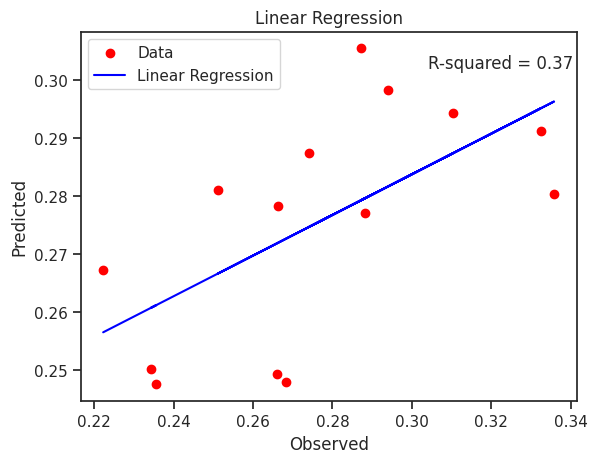

In [126]:
# linear regression nalysis

# Reshape the variables if needed (assuming they are 1D arrays)
x_obs = df_obs['mc'].values.reshape(-1, 1)
x_pred = df_pred['mc_pred'].values.reshape(-1, 1)

# Create a LinearRegression model
model = LinearRegression()

# Fit the model to the data
model.fit(x_obs, x_pred)

# Get the coefficients and intercept of the linear model
coef = model.coef_
intercept = model.intercept_

# Generate the predicted values using the linear model
y_pred = model.predict(x_obs)

# Calculate the R-squared value
r2 = r2_score(x_pred, y_pred)

# Create a scatter plot of the data points
plt.scatter(x_obs, x_pred, color='red', label='Data')

# Plot the linear regression line
plt.plot(x_obs, y_pred, color='blue', label='Linear Regression')

# Annotate the R-squared value
plt.annotate(f'R-squared = {r2:.2f}', xy=(0.7, 0.9), xycoords='axes fraction', fontsize=12)

# Set labels and title
plt.xlabel('Observed')
plt.ylabel('Predicted')
plt.title('Linear Regression')

# Show the legend
plt.legend(loc='upper left')

# Show the plot
plt.show()
